In [4]:
import pandas as pd
import numpy as np
import itertools
from collections import defaultdict

# display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# custom helper functions
%load_ext autoreload
%autoreload 2
# from helper.general_helper import *
# from helper.keras_predictions import *

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer

# view plotly in jupyter 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Reduce Sparcity

In [8]:
df = pd.read_csv("../../merged_df.csv")

In [9]:
df = df[df['title'].notna()]

# select reviewer and product values
customers = df['reviewerID'].value_counts()
products = df['asin'].value_counts()

# filter by 10 reviews per product per customer, products with 20 or more reviews
customers = customers[customers >= 10]
products = products[products >= 20]

# merge dataframe
df = df.merge(pd.DataFrame({'reviewerID': customers.index})).merge(pd.DataFrame({'asin': products.index}))


# select test size
n = 39601

# shuffle dataframe
df = df.sample(frac=1).reset_index(drop=True)

# split into train and test set
df_train = df[:-n]
df_test = df[-n:]

#### Recommending off KMeans

In [10]:
# create user product privot table
pivot_df = df.pivot_table(index='reviewerID', columns='asin', values='overall', fill_value=0)

# set cluster at 100
kmeans = KMeans(n_clusters=100, random_state=0).fit(pivot_df)

# redict users belonging to clusters
preds = kmeans.predict(pivot_df)

# create a dictionary with user id and their predicted class for mapping
user_pred_dict = defaultdict(int)
for user, pred in zip(pivot_df.index, preds):
    user_pred_dict[user] = pred
    
    
# create class column for users based on kmeans    
df['class'] = df.reviewerID.apply(lambda x: user_pred_dict[x])

# find overall mean per cluster for recommendations
pred_dict = dict(df.groupby('class').mean().overall)

# create a predicted column for each user
df['preds'] = df['class'].apply(lambda x: pred_dict[x])

In [11]:

# testing RMSE
test_values = df[['overall', 'preds']]


rmse = np.sqrt(mean_squared_error(test_values['overall'], test_values['preds']))
rmse

1.0403417066684297

In [ ]:
# plot the distribution of error
error = abs(df['overall'] - df['preds'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: KMeans', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/kmeans_error");

##### Testing Agglomerative Clustering with Ward linkage

In [14]:
# set clustering
alg = AgglomerativeClustering(n_clusters=100)
preds = alg.fit_predict(pivot_df)

# create mapping dictionary
user_pred_dict = defaultdict(int)
for user, pred in zip(pivot_df.index, preds):
    user_pred_dict[user] = pred
    
# asigning classes    
df['class'] = df.reviewerID.apply(lambda x: user_pred_dict[x])

# get user predictions
pred_dict = dict(df.groupby('class').mean().overall)

# set prediction column
df['preds'] = df['class'].apply(lambda x: pred_dict[x])

In [15]:
test_values = df[['overall', 'preds']]

rmse = np.sqrt(mean_squared_error(test_values['overall'], test_values['preds']))
rmse

1.0342468254176373

Text(0, 0.5, 'Count')

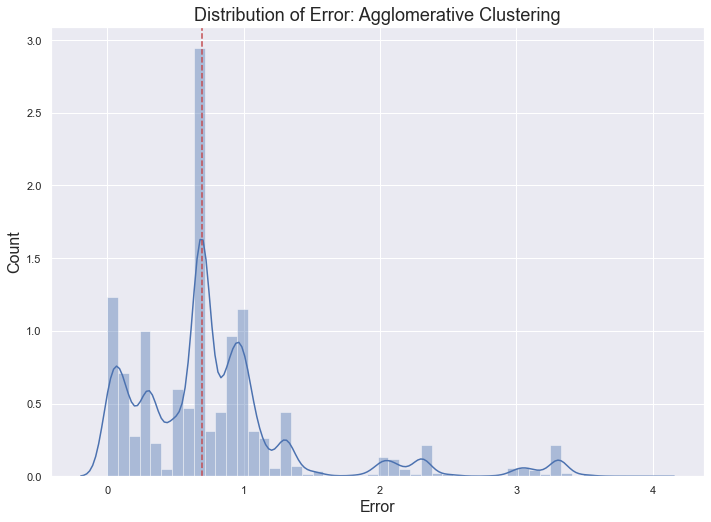

In [17]:
error = abs(df['overall'] - df['preds'])

figure = sns.distplot(error, kde=True)
plt.axvline(np.median(error),color='r', linestyle='--')
plt.title('Distribution of Error: Agglomerative Clustering', fontsize=18)
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.xlabel('Error', fontsize=16)
plt.ylabel('Count', fontsize=16)
# plt.savefig(r"../images/kmeans_error");